# FoEM
## Part 2: Public Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler  
from math import sqrt
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load dataset
df = pd.read_csv('Gold Price.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

In [5]:

# Dataset Overview
print("Shape of dataset:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
display(df.describe())


Shape of dataset: (2848, 6)

Data Types:
 Price       int64
Open        int64
High        int64
Low         int64
Volume      int64
Chg%      float64
dtype: object

Missing values:
 Price     0
Open      0
High      0
Low       0
Volume    0
Chg%      0
dtype: int64


,Price,Open,High,Low,Volume,Chg%
count,2848.000000,2848.000000,2848.000000,2848.000000,2848.000000,2848.000000
mean,41221.788624,41223.038975,41443.228230,41002.117275,12592.610253,0.037324
std,14374.500657,14375.130049,14451.199655,14300.609162,10643.504531,0.829900
min,24545.000000,24583.000000,24635.000000,24470.000000,0.000000,-5.980000
25%,29168.750000,29154.000000,29294.500000,29002.000000,6307.500000,-0.380000
50%,33939.000000,33945.000000,34229.500000,33743.000000,10830.000000,0.040000
75%,50824.000000,50819.000000,51071.000000,50551.000000,16472.500000,0.460000
max,79257.000000,79264.000000,79999.000000,78888.000000,106920.000000,5.300000


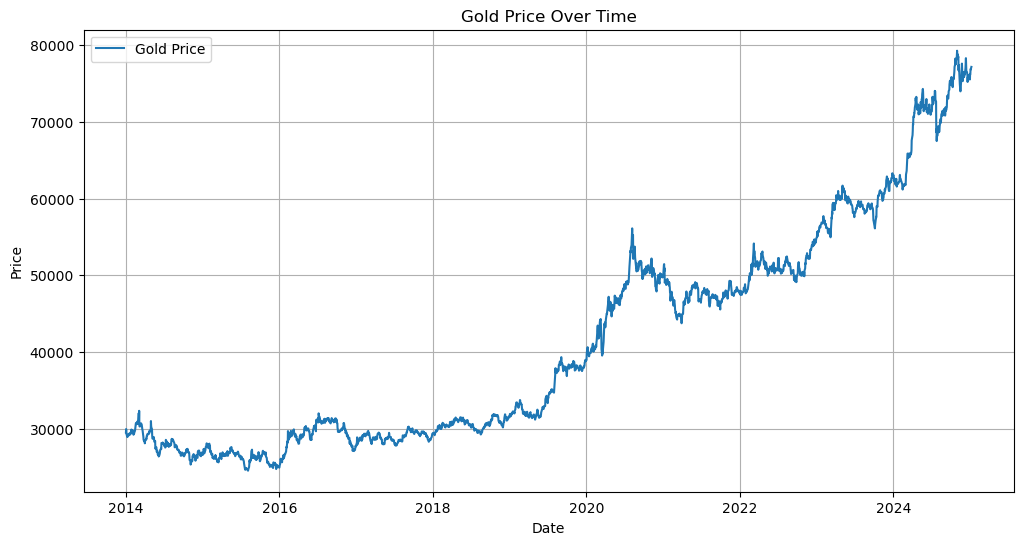

In [6]:

# EDA
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], label='Gold Price')
plt.title('Gold Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

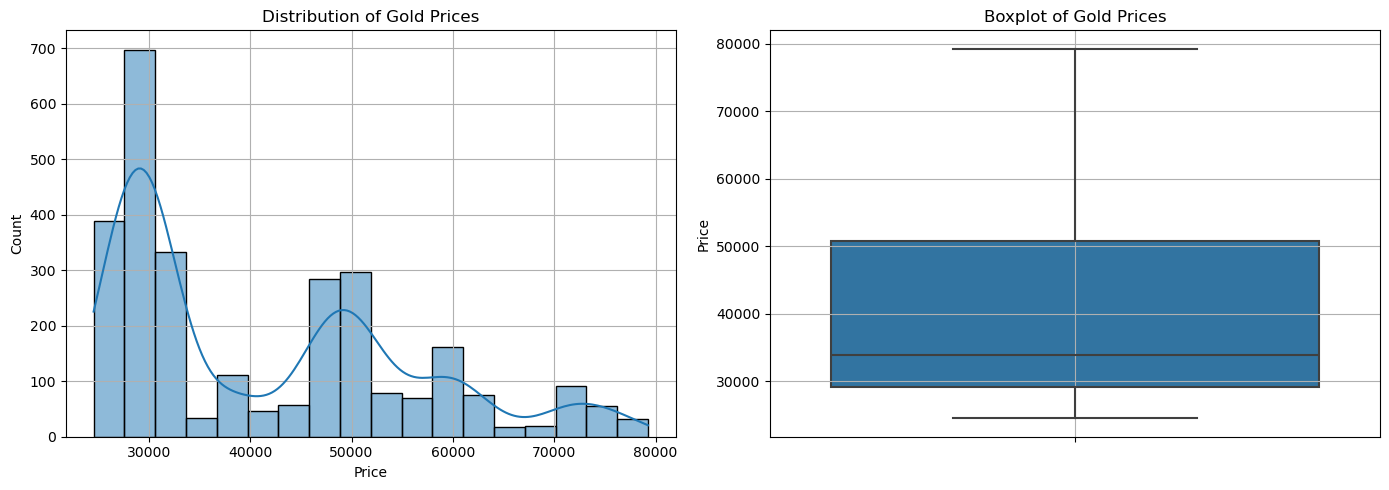

In [7]:
# Plot distribution and boxplot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution plot
sns.histplot(df['Price'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Gold Prices')
axes[0].set_xlabel('Price')
axes[0].grid(True)

# Box plot
sns.boxplot(y=df['Price'], ax=axes[1])
axes[1].set_title('Boxplot of Gold Prices')
axes[1].set_ylabel('Price')
axes[1].grid(True)

plt.tight_layout()
plt.show()

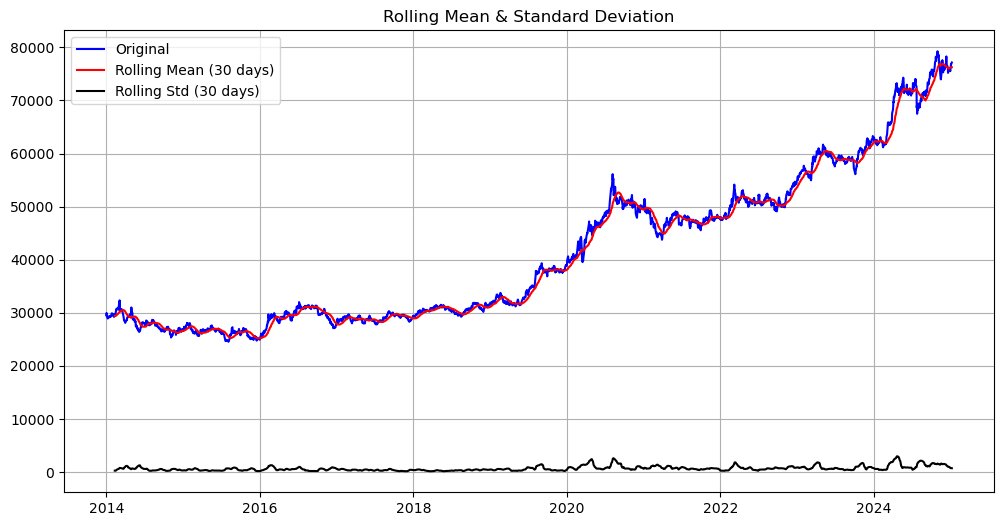

ADF Statistic: 1.3430283575181472
p-value: 0.9968393159173057
Critical Value (1%): -3.432650601050801
Critical Value (5%): -2.8625564475120617
Critical Value (10%): -2.567311085183206

Conclusion: The series is likely non-stationary (fail to reject null hypothesis).


In [8]:
# 3. Stationarity Check (Rolling Statistics + ADF Test)

# Plot rolling mean and std
rolling_mean = df['Price'].rolling(window=30).mean()
rolling_std = df['Price'].rolling(window=30).std()

plt.figure(figsize=(12, 6))
plt.plot(df['Price'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean (30 days)')
plt.plot(rolling_std, color='black', label='Rolling Std (30 days)')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.grid(True)
plt.show()

# Perform ADF Test
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

# Conclusion
if result[1] <= 0.05:
    print("\nConclusion: The series is likely stationary (reject null hypothesis at 5% level).")
else:
    print("\nConclusion: The series is likely non-stationary (fail to reject null hypothesis).")


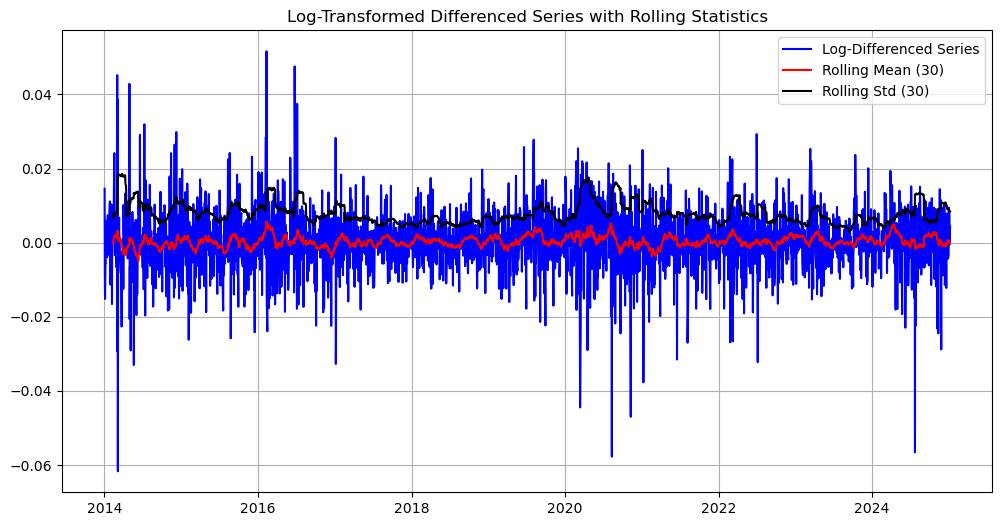

ADF Statistic (Log-Diff): -36.87948559532253
p-value: 0.0
Critical Value (1%): -3.432650601050801
Critical Value (5%): -2.8625564475120617
Critical Value (10%): -2.567311085183206

Conclusion: The log-differenced series is likely stationary (reject null hypothesis).


In [9]:
# 4. Make Series Stationary (Log Transform + Differencing + ADF)

# Log transformation
df_log = np.log(df['Price'])

# First differencing
df_log_diff = df_log.diff().dropna()

# Rolling mean and std for differenced log series
rolling_mean = df_log_diff.rolling(window=30).mean()
rolling_std = df_log_diff.rolling(window=30).std()

plt.figure(figsize=(12, 6))
plt.plot(df_log_diff, label='Log-Differenced Series', color='blue')
plt.plot(rolling_mean, label='Rolling Mean (30)', color='red')
plt.plot(rolling_std, label='Rolling Std (30)', color='black')
plt.title('Log-Transformed Differenced Series with Rolling Statistics')
plt.legend()
plt.grid(True)
plt.show()

# ADF Test on log-differenced series
result_diff = adfuller(df_log_diff)
print('ADF Statistic (Log-Diff):', result_diff[0])
print('p-value:', result_diff[1])
for key, value in result_diff[4].items():
    print(f'Critical Value ({key}): {value}')

# Conclusion
if result_diff[1] <= 0.05:
    print("\nConclusion: The log-differenced series is likely stationary (reject null hypothesis).")
else:
    print("\nConclusion: The log-differenced series is likely non-stationary (fail to reject null hypothesis).")


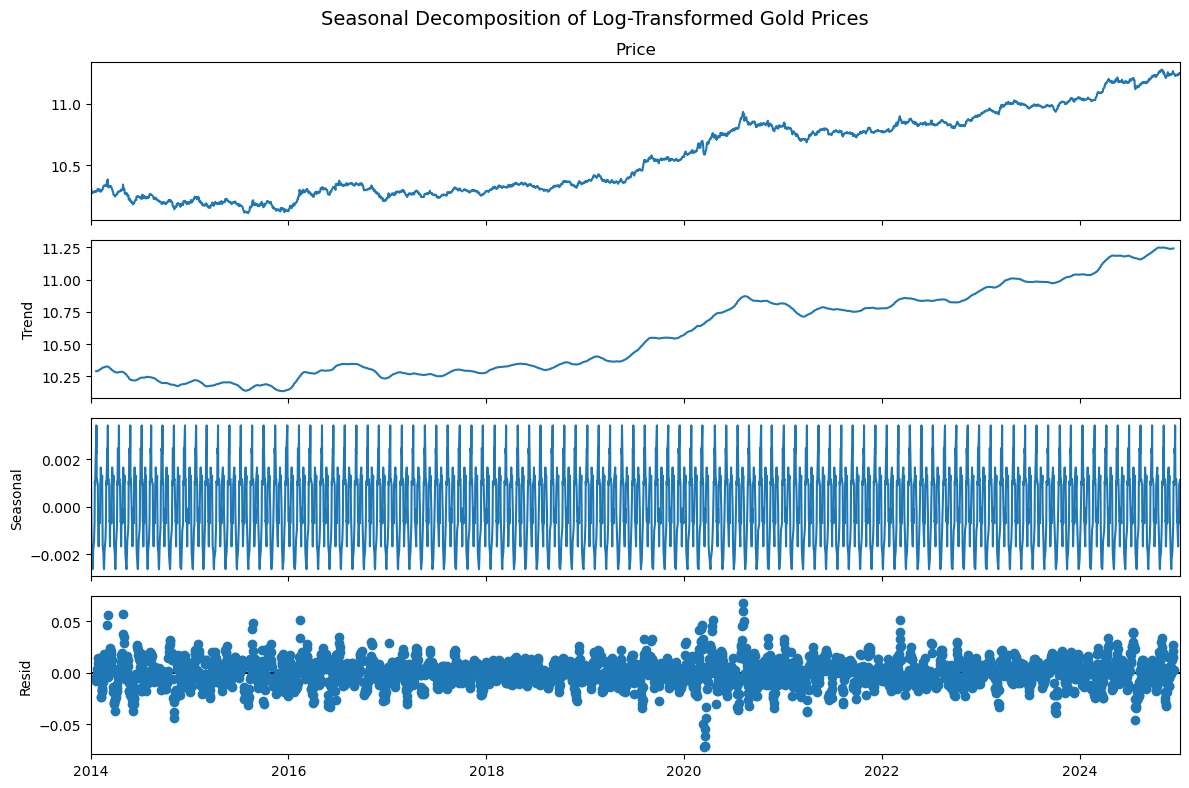

In [10]:
# 5. Seasonal Decomposition (on Log-Transformed Series)

# Use log-transformed series for clearer trend/seasonality
decomp = seasonal_decompose(df_log, model='additive', period=30)

# Plot all components
fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Seasonal Decomposition of Log-Transformed Gold Prices', fontsize=14)
plt.tight_layout()
plt.show()


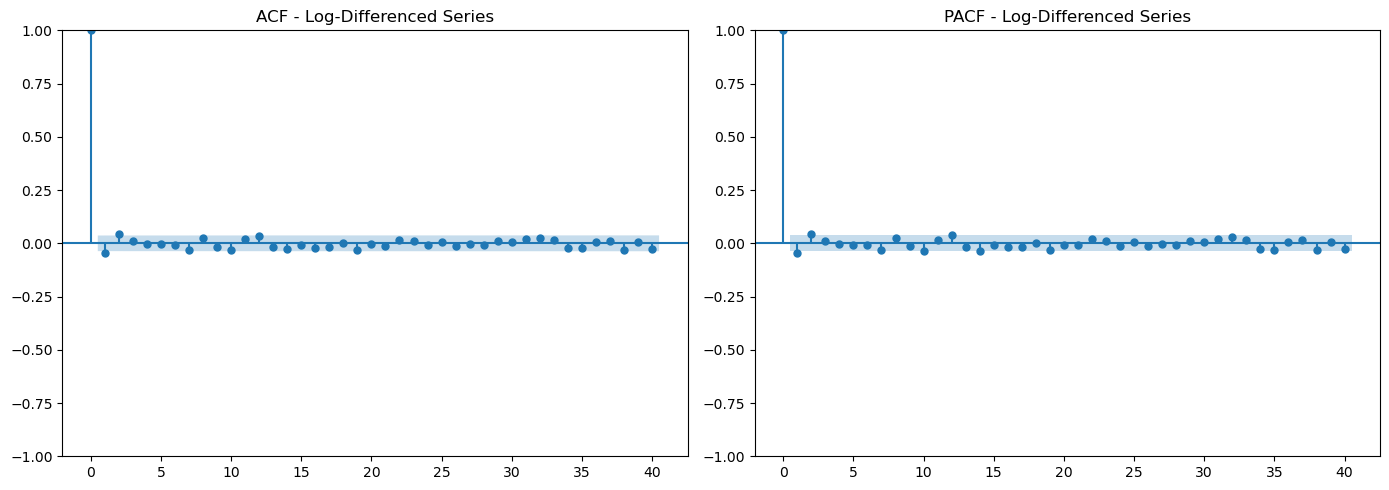

In [11]:
# 6. ACF and PACF (on Log-Differenced Series)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF
plot_acf(df_log_diff, lags=40, ax=axes[0])
axes[0].set_title('ACF - Log-Differenced Series')

# PACF
plot_pacf(df_log_diff, lags=40, ax=axes[1])
axes[1].set_title('PACF - Log-Differenced Series')

plt.tight_layout()
plt.show()


In [12]:
# 7. Train-test split (80/20) on Log-Transformed Series

# Use log-transformed series for modeling
df_log = np.log(df['Price'])

# Create train-test split
split_index_log = int(len(df_log) * 0.8)
train_log, test_log = df_log[:split_index_log], df_log[split_index_log:]

print(f"Training set (log): {train_log.shape}")
print(f"Testing set (log): {test_log.shape}")

Training set (log): (2278,)
Testing set (log): (570,)


In [36]:
# Step 1: Log-transform and convert to DataFrame
df_log_df = np.log(df['Price']).reset_index()
df_log_df.columns = ['ds', 'y']  # Rename to Prophet-style: Date → ds, log(Price) → y


In [14]:
# Step 2: Split
split_index = int(len(df_log_df) * 0.8)
train_log_df = df_log_df.iloc[:split_index]
test_log_df = df_log_df.iloc[split_index:]

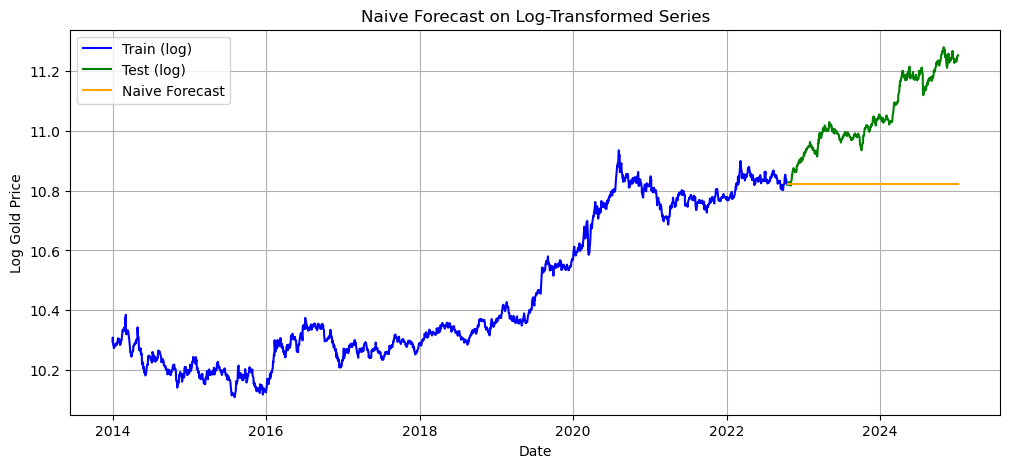

In [15]:
# Step 3: Naive forecast
last_train_value = train_log_df['y'].iloc[-1]
naive_forecast = pd.Series(last_train_value, index=test_log_df['ds'])

# Step 4: Plot
plt.figure(figsize=(12, 5))
plt.plot(train_log_df['ds'], train_log_df['y'], label='Train (log)', color='blue')
plt.plot(test_log_df['ds'], test_log_df['y'], label='Test (log)', color='green')
plt.plot(naive_forecast.index, naive_forecast.values, label='Naive Forecast', color='orange')
plt.title("Naive Forecast on Log-Transformed Series")
plt.xlabel("Date")
plt.ylabel("Log Gold Price")
plt.legend()
plt.grid(True)
plt.show()

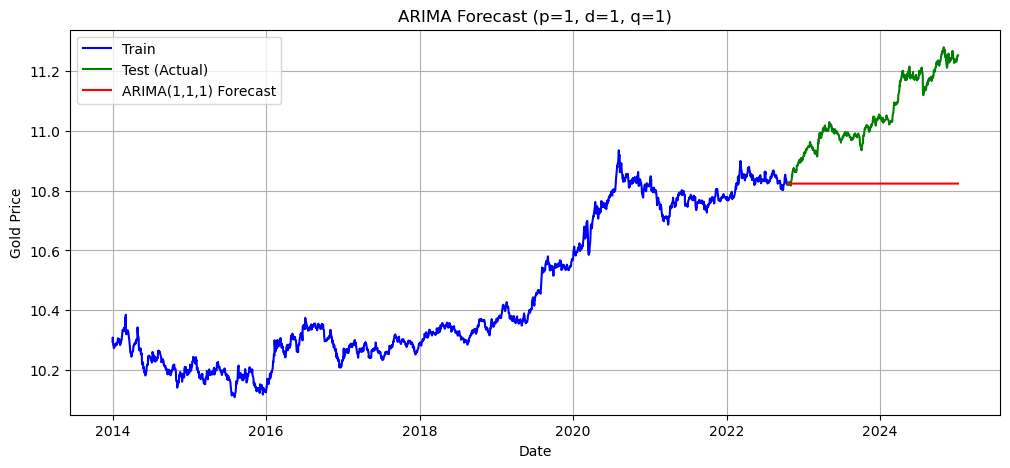

In [16]:
# Fit ARIMA model
model_arima = ARIMA(train_log, order=(1, 1, 1))
model_arima_fit = model_arima.fit()

# Forecast for test period
forecast_arima = model_arima_fit.forecast(steps=len(test_log))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(train_log.index, train_log, label='Train', color='blue')
plt.plot(test_log.index, test_log, label='Test (Actual)', color='green')
plt.plot(test_log.index, forecast_arima, label='ARIMA(1,1,1) Forecast', color='red')
plt.title("ARIMA Forecast (p=1, d=1, q=1)")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.show()

14:09:41 - cmdstanpy - INFO - Chain [1] start processing
14:09:44 - cmdstanpy - INFO - Chain [1] done processing


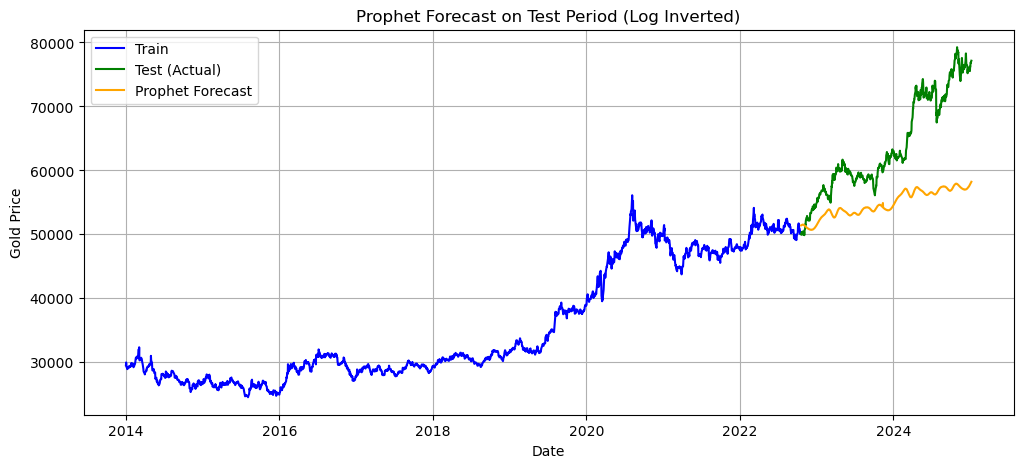

In [17]:

# Prophet Forecast on Log-Transformed Series

# Prepare log-transformed data
df_prophet_log = df.copy()
df_prophet_log['y'] = np.log(df_prophet_log['Price'])
df_prophet_log = df_prophet_log.reset_index().rename(columns={'Date': 'ds'})[['ds', 'y']]

# Split
split_idx = int(len(df_prophet_log) * 0.8)
train_log = df_prophet_log.iloc[:split_idx]
test_log = df_prophet_log.iloc[split_idx:]

# Train Prophet
model_prophet = Prophet()
model_prophet.fit(train_log)

# Forecast only for the test period
future = test_log[['ds']]
forecast = model_prophet.predict(future)

# Invert forecast to original scale
forecast['yhat_exp'] = np.exp(forecast['yhat'])
test_log['y_exp'] = np.exp(test_log['y'])

# Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(train_log['ds'], np.exp(train_log['y']), label='Train', color='blue')
plt.plot(test_log['ds'], test_log['y_exp'], label='Test (Actual)', color='green')
plt.plot(forecast['ds'], forecast['yhat_exp'], label='Prophet Forecast', color='orange')
plt.title("Prophet Forecast on Test Period (Log Inverted)")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
def mean_absolute_percentage_error(y_true, y_pred):  
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Invert all forecasts to original scale
y_true = np.exp(test_log_df['y'])
y_pred_naive = np.exp(naive_forecast.values)
y_pred_arima = np.exp(forecast_arima.values)
y_pred_prophet = forecast['yhat_exp'].values

# Evaluation Report
metrics = {
    "Model": [],
    "MAE": [],
    "RMSE": [],
    "MAPE (%)": [],
    "R² Score": []
}

def evaluate(name, y_true, y_pred):
    metrics["Model"].append(name)
    metrics["MAE"].append(mean_absolute_error(y_true, y_pred))
    metrics["RMSE"].append(np.sqrt(mean_squared_error(y_true, y_pred)))
    metrics["MAPE (%)"].append(mean_absolute_percentage_error(y_true, y_pred))
    metrics["R² Score"].append(r2_score(y_true, y_pred))

# Evaluate all
evaluate("Naive (exp)", y_true, y_pred_naive)
evaluate("ARIMA (exp)", y_true, y_pred_arima)
evaluate("Prophet (exp)", y_true, y_pred_prophet)

# Display results
eval_df = pd.DataFrame(metrics)
print("Evaluation Summary (Original Scale):")
display(eval_df)


Evaluation Summary (Original Scale):


,Model,MAE,RMSE,MAPE (%),R² Score
0,Naive (exp),13641.378947,15624.765260,20.266769,-3.197969
1,ARIMA (exp),13635.591544,15619.622288,20.257618,-3.195206
2,Prophet (exp),9070.985394,10724.198016,13.380824,-0.977616
